In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.nn.init as init
import time

In [9]:
def np_to_torch(arr):
    
    arr = torch.FloatTensor(arr)
    arr = arr.unsqueeze(-1)
    arr = arr.clone().detach().requires_grad_(True)
    
    return arr

def x_train_data(N_x, x_l, x_r, N_bc, N_ic, N_t, null):

    mse = nn.MSELoss(reduction='sum')
    x_train = np.geomspace(x_l+0.001, x_r, N_x)
    x_train = np.tile(x_train, N_t)
    x_bc1 = np.zeros(N_bc)
    x_bc2 = np.ones(N_bc)*x_r
    x_ic = np.random.uniform(low=x_l, high=x_r, size=(N_ic,))
    x_train = np.concatenate((x_train,x_bc1,x_bc2,x_ic),0)
    x_train = np_to_torch(x_train)
    N_xl = mse( torch.where(x_train == x_l,1,0), null ).detach().numpy().item()
    N_xr = mse( torch.where(x_train == x_r,1,0), null ).detach().numpy().item()
    
    return x_train, N_xl, N_xr

def t_train_data(t_i,t_f,N_t,N_x,N_bc,N_ic):
    
    t_train = np.linspace(t_i, t_f, N_t)
    t_train = np.repeat(t_train, N_x)
    t_bc1 = np.random.uniform(low=t_i, high=t_f, size=(N_bc,))
    t_bc2 = np.random.uniform(low=t_i, high=t_f, size=(N_bc,))
    t_ic = np.zeros(N_ic)
    t_train = np.concatenate((t_train,t_bc1,t_bc2,t_ic),0)
    t_train = np_to_torch(t_train)

    return t_train
            
def xavier_init(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.05)
    
class ANN(nn.Module):
    def __init__(self, layer_size):
        super(ANN, self).__init__()
        
        # Fully conected model
        modules = []
        for i in range(len(layer_size) - 1):
            modules.append(nn.Linear(layer_size[i], layer_size[i+1]))  
            modules.append(nn.Tanh())

        self.fc = nn.Sequential(*modules)
        self.fc.apply(xavier_init)
        
    def forward(self, x_train, t_train):
        op = self.fc( torch.cat((x_train, t_train), 1) )
        op_x = torch.autograd.grad(op, x_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        op_x2 = torch.autograd.grad(op_x, x_train, grad_outputs=torch.ones_like(op_x), create_graph=True)[0]
        op_t = torch.autograd.grad(op, t_train, grad_outputs=torch.ones_like(op), create_graph=True)[0]
        return op, op_t, op_x2
    
def get_loss(x_train, t_train, k1, N_tot, N_ic, T_l, T_r, N_xl, N_xr, x_l, x_r, T_ini, null):
    
    mse = nn.MSELoss(reduction='sum')
    
    w1 = 1
    w2 = 1
    w3 = 1
    w4 = 1
    T, dTdt, d2Tdx2 = model(x_train, t_train)
    eq1 = w1*mse(dTdt, k1*d2Tdx2)/(N_tot)
    ic = w2*( mse( torch.mul( torch.where(t_train == 0,1,0), (T - T_ini) ), null ) )/(N_ic)
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)), null )/(N_xl)
    bc2 = w4*mse( torch.mul(torch.where(x_train == x_r,1,0),(T - T_r)), null )/(N_xr)
    loss = eq1 + bc1 + bc2 + ic
    
    return loss, eq1, bc1, bc2, ic

def print_loss(epoch, loss, eq1, bc1, bc2, ic):
    print('epoch = ',epoch)
    print('loss = ',loss.detach().numpy())
    print('eq1_loss = ',eq1.detach().numpy())
    print('bc1_loss = ',bc1.detach().numpy())
    print('bc2_loss = ',bc2.detach().numpy())
    print('ic_loss = ',ic.detach().numpy())
    
def L2_err(N_x_test, N_t_test, x_test, t_test, y_an, model):
    
    x_test = np_to_torch(x_test)
    t_test = np_to_torch(t_test)
    y_pred,_,_  = model(x_test, t_test)
    y_pred = y_pred.detach().numpy()

    L2_err =  np.sum((y_an - y_pred)**2)/(N_x_test*N_t_test)
    return L2_err

def analytical(N_x_test, N_t_test, x_l, x_r, t_f):
    
    x_test = np.linspace(x_l, x_r, N_x_test)
    x_test = np.tile(x_test, N_t_test)
    t_test = np.linspace(0, t_f, N_t_test)
    t_test = np.repeat(t_test, N_x_test)

    i = 1
    y_an = 0
    for i in range(1, 49, 1): 
        y_an += -2*T_l*(-1)**(i+1)/(i*np.pi)*np.sin(i*np.pi*(1 - x_test))*np.exp(-i**2*np.pi**2*k1*t_test)   
    y_an += T_l*(1 - x_test)
    
    y_an = y_an.reshape(N_x_test*N_t_test,1)
    
    return y_an, x_test, t_test
    
    
def train_model(model, optimiser1, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, N_ic, t_arr, t_i, T_ini, accuracy_cap,  N_x_test, N_t_test):
    
    loss_store = []
    mse = nn.MSELoss(reduction='sum')
    model.train()  
    
    start = time.time()
    y_an1, x_test1, t_test1 = analytical(N_x_test, N_t_test, x_l, x_r, t_arr[-1])
    for j in range(len(t_arr)-1):
        
        if(j==0):
            epochs = 15000
        else:
            epochs = 2000
            
        N_t_fin = int( ( t_arr[j+1] - t_arr[j] )*N_t )
        N_bc_fin = int( ( t_arr[j+1] - t_arr[j] )*N_bc )
        N_ic_fin = int( ( t_arr[j+1] - t_arr[j] )*N_ic )
        print("N_t_fin = ", N_t_fin)
            
        # Training data    
        N_tot = N_x*N_t_fin + 2*N_bc_fin + N_ic_fin
        null = torch.zeros(N_tot).unsqueeze(-1)
        x_train, N_xl, N_xr = x_train_data(N_x, x_l, x_r, N_bc_fin, N_ic_fin, N_t_fin, null)
        t_train = t_train_data(0,t_arr[j+1],N_t_fin,N_x,N_bc_fin,N_ic_fin)
        N_ic_fin = mse( torch.where(t_train == t_i,1,0) , null).detach().numpy().item()
        print("x_train = ", x_train.shape)
        print("t_train = ", t_train.shape)
        print("")
        
        # Test Data
        N_t_test_2 = int( N_t_test*( t_arr[j+1] - t_arr[j] ) )
        y_an2, x_test2, t_test2 = analytical(N_x_test, N_t_test_2, x_l, x_r, t_arr[j+1])

        # Adam optimiser loop
        for epoch in range(epochs):
            
            #Backpropogation and optimisation
            loss, eq1, bc1, bc2, ic = get_loss(x_train, t_train, k1, N_tot, N_ic_fin,T_l, T_r, N_xl, N_xr, x_l, x_r, T_ini, null)
            optimiser1.zero_grad()
            loss.backward()
            optimiser1.step()  
            loss_store.append(loss.detach().numpy())

            L2_norm_err_1 = L2_err(N_x_test, N_t_test, x_test1, t_test1, y_an1, model)
#             L2_norm_err_2 = L2_err(N_x_test, N_t_test_2, x_test2, t_test2, y_an2, model)
            
            if epoch%400==0:
                print_loss(epoch, loss, eq1, bc1, bc2, ic)
                print("L2_err_1= ", L2_norm_err_1 )
#                 print("L2_err_2= ", L2_norm_err_2 )
                print("")
                
            if epoch%1000==0:
                print("time = ", time.time() - start)
                print("")
            
            
            if L2_norm_err_1<accuracy_cap: 
                print("loss limit attained, epoch = ", epoch)
                print("")
                break
            
        print("broke inner loop")
        print("")
        
#         if(L2_norm_err_1<accuracy_cap):
#             break
        
    end = time.time()

    return end-start, loss_store

In [13]:
N_x = 35
N_bc = 101
N_ic = 101
N_t = 101
x_l = 0
x_r = 1
t_i = 0
T_r = 0
T_l = 1
T_ini = 0
accuracy_cap = 0.0001
N_x_test = 100
N_t_test = 100
t_arr = [0, 1]

# Neural network params
layer_size = [2, 35, 35, 35, 35, 35, 35, 1]

# material params
k1 = 0.05

# # Training data and initial data
model = ANN(layer_size)
print(model)
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# # Setup Loss function and Optimiser
# lr = 6e-5
lr = 1e-4
epochs = 15000
optimiser = torch.optim.AdamW(model.parameters(), lr=lr)

# Training model
time_elapsed, loss_store = train_model(model, optimiser, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, N_ic, t_arr, t_i, T_ini, accuracy_cap, N_x_test, N_t_test)
print("time elapsed = ", time_elapsed)

ANN(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=35, bias=True)
    (1): Tanh()
    (2): Linear(in_features=35, out_features=35, bias=True)
    (3): Tanh()
    (4): Linear(in_features=35, out_features=35, bias=True)
    (5): Tanh()
    (6): Linear(in_features=35, out_features=35, bias=True)
    (7): Tanh()
    (8): Linear(in_features=35, out_features=35, bias=True)
    (9): Tanh()
    (10): Linear(in_features=35, out_features=35, bias=True)
    (11): Tanh()
    (12): Linear(in_features=35, out_features=1, bias=True)
    (13): Tanh()
  )
)
Total trainable parameters in the model: 6441
N_t_fin =  101
x_train =  torch.Size([3838, 1])
t_train =  torch.Size([3838, 1])

epoch =  0
loss =  1.1152796
eq1_loss =  0.02119454
bc1_loss =  1.0460241
bc2_loss =  0.04341016
ic_loss =  0.0046507083
L2_err_1=  0.1059186302547811

time =  0.14086389541625977



KeyboardInterrupt: 

# Results Plotter

In [ ]:
y_an, x_test, t_test = analytical(N_x_test, N_t_test, x_l, x_r, 1)
x_test = np_to_torch(x_test)
t_test = np_to_torch(t_test)
y_pred, dTdt, d2Tdx2 = model(x_test, t_test)
x_test = x_test.detach().numpy()
y_pred = y_pred.detach().numpy()
# 
j = 90

plt.plot(x_test[j*N_t_test:(j+1)*N_t_test], y_pred[j*N_t_test:(j+1)*N_t_test])
plt.plot(x_test[j*N_t_test:(j+1)*N_t_test], y_an[j*N_t_test:(j+1)*N_t_test])
plt.legend(["PINN", "Analytical"])
plt.show()

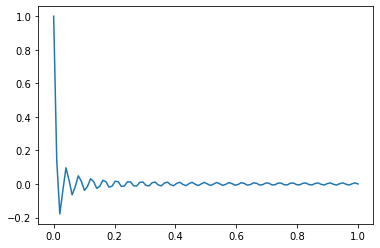

In [15]:
j = 0
y_an, x_test, t_test = analytical(N_x_test, N_t_test, x_l, x_r, 1)
plt.plot(x_test[j*N_t_test:(j+1)*N_t_test], y_an[j*N_t_test:(j+1)*N_t_test])

In [18]:
y_an[j*N_t_test:(j+1)*N_t_test]

array([[ 1.00000000e+00],
       [ 1.40325479e-01],
       [-1.78601539e-01],
       [-3.68885874e-02],
       [ 9.64206950e-02],
       [ 2.24677590e-02],
       [-6.50536154e-02],
       [-1.79388232e-02],
       [ 4.85522276e-02],
       [ 1.59468512e-02],
       [-3.83320755e-02],
       [-1.48759376e-02],
       [ 3.13356798e-02],
       [ 1.42115439e-02],
       [-2.62090982e-02],
       [-1.37497120e-02],
       [ 2.22626959e-02],
       [ 1.33968281e-02],
       [-1.91089750e-02],
       [-1.31051490e-02],
       [ 1.65137589e-02],
       [ 1.28483167e-02],
       [-1.43273471e-02],
       [-1.26108591e-02],
       [ 1.24496713e-02],
       [ 1.23832444e-02],
       [-1.08113667e-02],
       [-1.21593727e-02],
       [ 9.36288479e-03],
       [ 1.19352221e-02],
       [-8.06792748e-03],
       [-1.17080814e-02],
       [ 6.89932742e-03],
       [ 1.14760952e-02],
       [-5.83637364e-03],
       [-1.12379844e-02],
       [ 4.86302412e-03],
       [ 1.09928687e-02],
       [-3.9

In [ ]:
# class weightedTanh(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, input):
#         ex = torch.exp(0.5*input)
#         return 1-2*((ex-1)/(ex+1))**2

In [ ]:
# class Training:
#     def __init__(self, model, optimiser1, optimiser2, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, N_ic, t_arr, t_i, T_ini):
        
#         self.model = model
#         self.epochs = epochs
#         self.T_r = T_r
#         self.T_l = T_l
#         self.k1 = k1
#         self.N_x = N_x
#         self.x_l = x_l
#         self.x_r = x_r
#         self.N_t = N_t
#         self.N_bc = N_bc
#         self.N_ic = N_ic
#         self.t_arr = t_arr
#         self.t_i = t_i
#         self.T_ini = T_ini
#         self.w1 = 1
#         self.w2 = 1
#         self.w3 = 1
#         self.w4 = 1
#         self.N_tot = self.N_x*self.N_t + 2*self.N_bc + self.N_ic
#         self.null = torch.zeros(self.N_tot, 1)
#         self.mse = nn.MSELoss(reduction='sum')
        
#     def x_train_data(self):
        
#         x_train = np.linspace(self.x_l, self.x_r, self.N_x)
#         x_train = np.tile(x_train, N_t)
#         x_bc1 = np.zeros(self.N_bc)
#         x_bc2 = np.ones(self.N_bc)*self.x_r
#         x_ic = np.random.uniform(low=self.x_l, high=self.x_r, size=(self.N_ic,))
#         x_train = np.concatenate((x_train,x_bc1,x_bc2,x_ic),0)
#         x_train = torch.FloatTensor(x_train)
#         x_train = x_train.unsqueeze(-1)
#         x_train = x_train.clone().detach().requires_grad_(True)
#         N_xl = self.mse( torch.where(x_train == self.x_l,1,0), self.null ).detach().numpy().item()
#         N_xr = self.mse( torch.where(x_train == self.x_r,1,0), self.null ).detach().numpy().item()
    
#         return x_train, N_xl, N_xr, a, b
    
#     def t_train_data(self, t_start, t_end):
        
#         t_train = np.linspace(t_start, t_end, self.N_t)
#         t_train = np.repeat(t_train, self.N_x)
#         t_bc1 = np.random.uniform(low = t_start, high= t_end, size=(self.N_bc,))
#         t_bc2 = np.random.uniform(low = t_start, high= t_end, size=(self.N_bc,))
#         t_ic = np.zeros(self.N_ic)
#         t_train = np.concatenate((t_train,t_bc1,t_bc2,t_ic),0)
#         t_train = torch.FloatTensor(t_train)
#         t_train = t_train.unsqueeze(-1)
#         t_train = t_train.clone().detach().requires_grad_(True)
    
#         return t_train, 
    
#     def get_loss(x_train, t_train, k1, N_tot, N_ic, a, b, T_l, T_r, N_xl, N_xr, x_l, x_r, T_ini, null):

#         T, dTdt, d2Tdx2 = model(x_train, t_train)
#         eq1 = self.w1*mse(dTdt, self.k1*d2Tdx2)/(self.N_tot)
#         ic = self.w2*( mse( torch.mul(a, T - T_l), null ) + mse( torch.mul(b, T - T_ini), null ) )/(N_ic)
#         bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - T_l)), null )/(N_xl)
#         bc2 = w4*mse( torch.mul(torch.where(x_train == x_r,1,0),(T - T_r)), null )/(N_xr)
#         loss = eq1 + bc1 + bc2 + ic
    
#         return loss, eq1, bc1, bc2, ic
    
#     def abcd(self):
#         print(self.t_arr[0])
#         print(self.t_arr[1])
#         t_train = self.t_train_data(self.t_arr[0], self.t_arr[1])
#         return t_train

In [ ]:
# boom = Training(model, optimiser1, optimiser2, epochs, T_r, T_l, k1, N_x, x_l, x_r, N_t, N_bc, N_ic, t_arr, t_i, T_ini)
# t_train = boom.abcd()